## About the Problem
A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and 36 percent for women. 

Brain tumor classification is a crucial task in medical imaging to assist radiologists in diagnosing brain tumors from MRI scans.
The goal of this project is to classify MRI images into four categories: Glioma Tumor, Meningioma Tumor, No Tumor, and Pituitary Tumor.

## About the Dataset
The dataset used for this project is the 'Brain Tumor Classification (MRI)' dataset from Kaggle. It contains:
- 3264 images in the training set
- 1011 images in the test set
- 4 classes: glioma_tumor, meningioma_tumor, no_tumor, pituitary_tumor
  


# Loading the Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from warnings import filterwarnings

In [3]:
base_dir = "/kaggle/input/"
train_path = os.path.join(base_dir, "Training/")
test_path = os.path.join(base_dir, "Testing/")

In [4]:
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

In [5]:
# Function to count images in each class folder
def count_images(data_path):
    print(f'For {data_path} :')
    for label in labels:
        path = os.path.join(data_path, label)
        images=os.listdir(path)
        num_images = len(images)
        print(f'{label}:{num_images} images')


In [6]:
count_images(train_path)
count_images(test_path)

For /kaggle/input/Training/ :
glioma_tumor:826 images
meningioma_tumor:822 images
no_tumor:395 images
pituitary_tumor:827 images
For /kaggle/input/Testing/ :
glioma_tumor:100 images
meningioma_tumor:115 images
no_tumor:105 images
pituitary_tumor:74 images


In [7]:
# Create Dataset folder by combining training and testing folders
dataset_path = "/kaggle/working/Dataset"
os.makedirs(dataset_path, exist_ok=True)

# Combine Training and Testing data into /Dataset/
for label in labels:
    train_label_path = os.path.join(train_path, label)
    test_label_path = os.path.join(test_path, label)
    dataset_label_path = os.path.join(dataset_path, label)

    os.makedirs(dataset_label_path, exist_ok=True)

    # Copy images from train and test into /Dataset/
    for img_name in os.listdir(train_label_path):
        shutil.copy(os.path.join(train_label_path, img_name), os.path.join(dataset_label_path, img_name))

    for img_name in os.listdir(test_label_path):
        shutil.copy(os.path.join(test_label_path, img_name), os.path.join(dataset_label_path, img_name))

print("Dataset creation complete.")
count_images(dataset_path)


Dataset creation complete.
For /kaggle/working/Dataset :
glioma_tumor:926 images
meningioma_tumor:937 images
no_tumor:396 images
pituitary_tumor:901 images


# Data Visualization

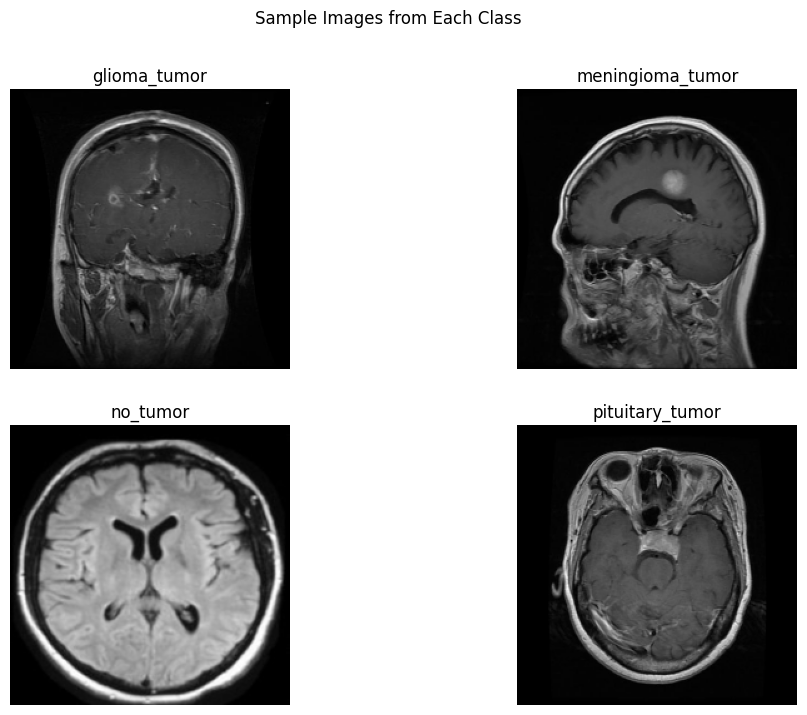

In [8]:
# Visualize sample images from each class
def plot_sample_images(data_path, labels, img_size=224):
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        folder_path = os.path.join(data_path, label)
        img_name = os.listdir(folder_path)[0]  # Pick first image from each folder
        img_path = os.path.join(folder_path, img_name)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    
    plt.suptitle("Sample Images from Each Class")
    plt.show()

plot_sample_images(dataset_path, labels)

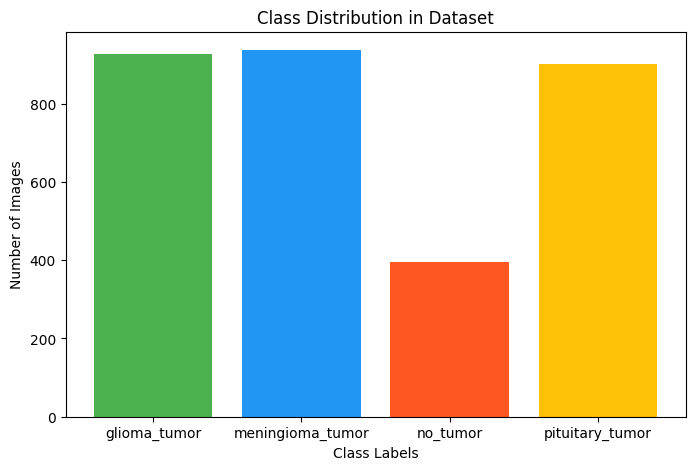

In [9]:
# Visualize class distribution in a bar chart
def plot_class_distribution(data_path, labels):
    class_counts = {label: len(os.listdir(os.path.join(data_path, label))) for label in labels}
    
    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color=['#4CAF50', '#2196F3', '#FF5722', '#FFC107'])
    plt.title("Class Distribution in Dataset")
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Images")
    plt.show()

plot_class_distribution(dataset_path, labels)

# Performing Data Augmentation

In [10]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to create augmented images and save them in respective folders
def augment_and_save(data_path, save_path, num_aug):
    for label in labels:  # Iterate using defined labels
        path = os.path.join(data_path, label)
        save_dir = os.path.join(save_path, label)

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            img = np.array([img])  # Wraps image in a list to create batch dimension

            # Generate and save augmented images
            aug_iter = datagen.flow(img, batch_size=num_aug,save_to_dir=save_dir,save_prefix='aug',save_format='jpg')
            next(aug_iter)

In [11]:
# Generate augmented images for train and test data
augment_and_save(dataset_path, dataset_path,3)  # Augment training data

In [12]:
count_images(dataset_path)

For /kaggle/working/Dataset :
glioma_tumor:1816 images
meningioma_tumor:1820 images
no_tumor:786 images
pituitary_tumor:1764 images


# Data Loading

In [13]:
def load_data(data_path, img_size=224):
    data = []

    for label in labels:
        folder_path = os.path.join(data_path, label)
        for img_name in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            data.append([img,label ])
    return data

In [14]:
data = load_data(dataset_path)

In [15]:
X=[]
y=[]

for features,label in data:
    X.append(features)
    y.append(label)

X=np.array(X)
y=np.array(y)

In [16]:
X, y = shuffle(X,y, random_state=101)

In [17]:
y

array(['glioma_tumor', 'meningioma_tumor', 'glioma_tumor', ...,
       'glioma_tumor', 'glioma_tumor', 'pituitary_tumor'], dtype='<U16')

# Data Preperation

In [18]:
from sklearn.model_selection import train_test_split

# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# Second split: Split Temp (30%) into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

# Confirm the sizes
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (4330, 224, 224, 3), (4330,)
Validation data shape: (928, 224, 224, 3), (928,)
Test data shape: (928, 224, 224, 3), (928,)


In [19]:
#Counts for y_train
label_counts = pd.Series(y_train.flatten()).value_counts()
print("Class Distribution for training:")
print( label_counts)

Class Distribution for training:
meningioma_tumor    1289
glioma_tumor        1254
pituitary_tumor     1232
no_tumor             555
Name: count, dtype: int64


In [20]:
# Counts for y_test
label_counts = pd.Series(y_test.flatten()).value_counts()
print("Class Distribution for testing:")
print( label_counts)

Class Distribution for testing:
pituitary_tumor     269
glioma_tumor        268
meningioma_tumor    267
no_tumor            124
Name: count, dtype: int64


In [21]:
# Counts for y_val
label_counts = pd.Series(y_val.flatten()).value_counts()
print("Class Distribution for validation:")
print( label_counts)

Class Distribution for validation:
glioma_tumor        294
meningioma_tumor    264
pituitary_tumor     263
no_tumor            107
Name: count, dtype: int64


In [22]:
# Perform one hot encoding
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

In [23]:
y_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

# Using EfficientNetB0(Transfer Learning)

*EfficientNet is a state-of-the-art CNN architecture that achieves better accuracy with fewer parameters than traditional models. EfficientNetB0 is the base model in the EfficientNet family and is highly efficient for image classification tasks.*


Key Features of EfficientNetB0: 
- Uses compound scaling, balancing depth, width, and resolution for optimal performance.
- Pretrained on ImageNet, leveraging transfer learning to improve accuracy with fewer data points.
-  Its lightweight design makes it ideal for medical imaging tasks where computational efficiency is crucial.


*By combining EfficientNetB0 with additional dense layers and dropout, the model aims to effectively capture complex patterns in MRI brain scans.*


In [24]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(224, 224, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
from tensorflow import keras
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Model Training

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_delta=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [27]:
history=model.fit(X_train,y_train , validation_data=(X_test,y_test), epochs=12,callbacks=[reduce_lr,early_stopping,model_checkpoint],verbose=1)

Epoch 1/12
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.6429 - loss: 0.8776
Epoch 1: val_accuracy improved from -inf to 0.75970, saving model to best_model.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 144s 492ms/step - accuracy: 0.6438 - loss: 0.8756 - val_accuracy: 0.7597 - val_loss: 0.6174 - learning_rate: 1.0000e-04
Epoch 2/12
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9184 - loss: 0.2317
Epoch 2: val_accuracy improved from 0.75970 to 0.85237, saving model to best_model.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9185 - loss: 0.2315 - val_accuracy: 0.8524 - val_loss: 0.4180 - learning_rate: 1.0000e-04
Epoch 3/12
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9660 - loss: 0.1093
Epoch 3: val_accuracy improved from 0.85237 to 0.87392, saving model to best_model.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.9660 - loss: 0.1092 - val_accuracy: 0.8739 - val_loss: 0.3340 - learning_rate: 1.0000e-04
Epoch 4/12
135/136 ━━━━━━━━

# Model Evaluation

In [28]:
# Evaluate the model
val_loss, val_acc = model.evaluate(X_val,y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9825 - loss: 0.0529
Validation Loss: 0.08298303931951523
Validation Accuracy: 0.9762930870056152


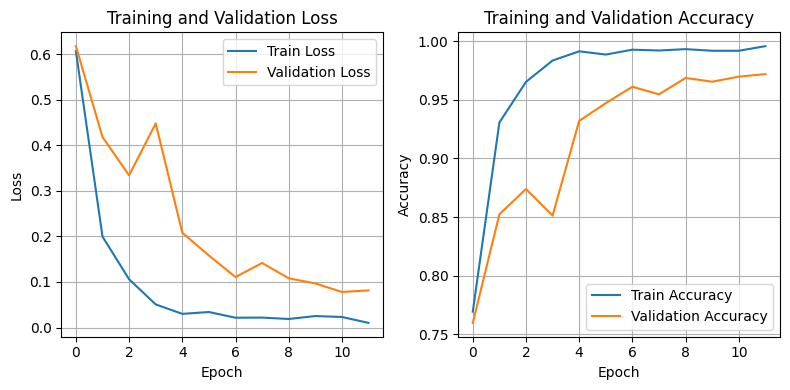

In [29]:
# Plotting training and validation loss
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix and Classification Report

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step


Text(50.58159722222221, 0.5, 'True Label')

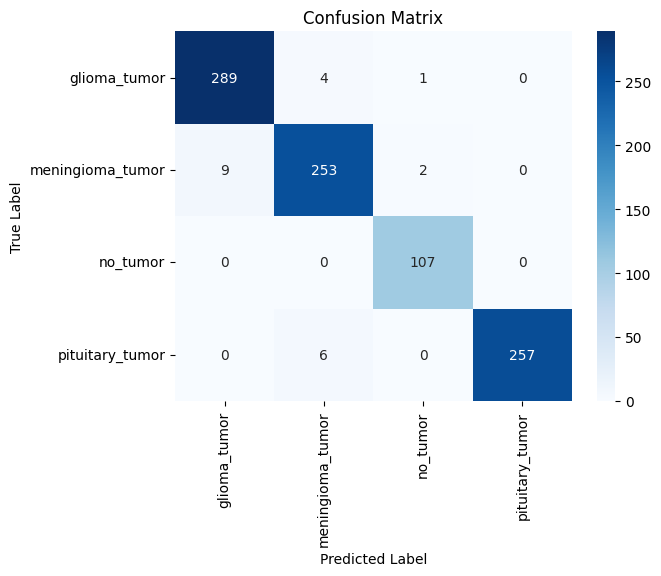

In [30]:
from sklearn.metrics import classification_report,confusion_matrix
y_true_test = np.argmax(y_val, axis=1)
y_pred_test = np.argmax(model.predict(X_val), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [31]:
# Print classification report
print("Classification Report (Testing Data):")
print(classification_report(y_true_test, y_pred_test,target_names=labels))


Classification Report (Testing Data):
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.98      0.98       294
meningioma_tumor       0.96      0.96      0.96       264
        no_tumor       0.97      1.00      0.99       107
 pituitary_tumor       1.00      0.98      0.99       263

        accuracy                           0.98       928
       macro avg       0.98      0.98      0.98       928
    weighted avg       0.98      0.98      0.98       928

